conda environment for this program:<br>
<code>conda activate jh_class</code>


In [115]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19
from pathlib import Path
from IPython.display import Image, display

BASE_PATH = "../../../../local_data/practice/jheaton/"
OUTPUT_PATH = BASE_PATH+"pr_class_09_5_style_fchollet/"

os.system("mkdir -p " + OUTPUT_PATH)

abs_path=str(Path.cwd())
base_path=abs_path.split("github")[0]+"github/local_data/practice/jheaton/pr_class_09_5_style_fchollet/"
# base_image_path_string="file://"+base_path+"paris.jpg"
base_image_path_string="file://"+base_path+"puma_03.jpg"
# base_image_path_string="file://"+base_path+"sylvia.jpg"
# style_reference_image_path_string="file://"+base_path+"starry_night.jpg"
style_reference_image_path_string="file://"+base_path+"azvolai.jpg"
print(base_image_path_string)
print(style_reference_image_path_string)

file:///media/data/github/local_data/practice/jheaton/pr_class_09_5_style_fchollet/puma_03.jpg
file:///media/data/github/local_data/practice/jheaton/pr_class_09_5_style_fchollet/azvolai.jpg


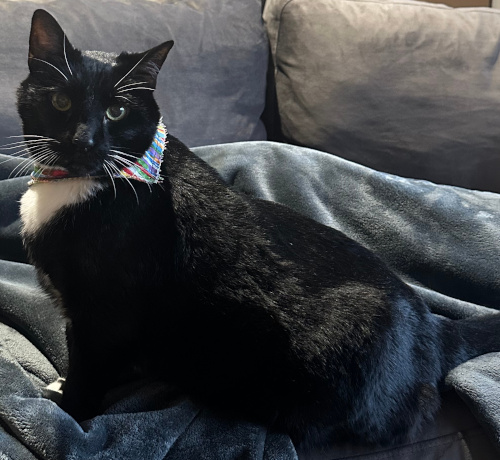

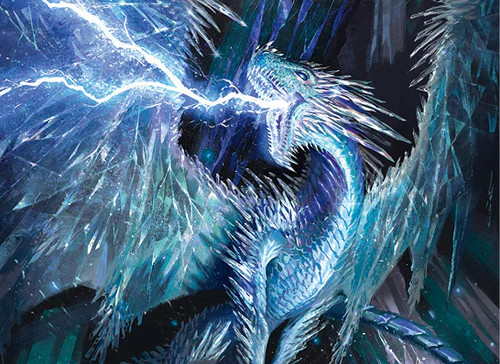

In [116]:
base_image_path = keras.utils.get_file(
    origin=base_image_path_string,
    extract=True,
)
style_reference_image_path = keras.utils.get_file(
    origin=style_reference_image_path_string,
    extract=True,
)
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [117]:
# Weights of the different loss components
total_variation_weight = 1e-6
# style_weight = 1e-6
style_weight = 2e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [118]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [119]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)
# model.summary()

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict)

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)
# feature_extractor.summary()


{'input_13': <KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_13')>, 'block1_conv1': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>, 'block1_conv2': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>, 'block1_pool': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>, 'block2_conv1': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>, 'block2_conv2': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>, 'block2_pool': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>, 'block3_conv1': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>, 'block3_conv2': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>, 'block3_conv3': <KerasTens

In [120]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

In [121]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [122]:

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [123]:
# iterations = 1000
# save_every_it=100

iterations = 5000
save_every_it=200

In [124]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads
    
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % save_every_it == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = "paris_generated_at_iteration_%04d.png" % i
        keras.utils.save_img(fname, img)


Iteration 200: loss=4303.78
Iteration 400: loss=3566.28
Iteration 600: loss=3267.36
Iteration 800: loss=3084.75
Iteration 1000: loss=2965.61
Iteration 1200: loss=2880.82
Iteration 1400: loss=2817.71
Iteration 1600: loss=2769.30
Iteration 1800: loss=2730.79
Iteration 2000: loss=2699.34
Iteration 2200: loss=2673.28
Iteration 2400: loss=2651.42
Iteration 2600: loss=2632.75
Iteration 2800: loss=2616.66
Iteration 3000: loss=2602.69
Iteration 3200: loss=2590.45
Iteration 3400: loss=2579.67
Iteration 3600: loss=2570.13
Iteration 3800: loss=2561.69
Iteration 4000: loss=2554.14
Iteration 4200: loss=2547.39
Iteration 4400: loss=2541.34
Iteration 4600: loss=2535.91
Iteration 4800: loss=2531.01
Iteration 5000: loss=2526.57


In [125]:

# for i in range(1, iterations + 1):
#     with tf.GradientTape() as tape:
#         loss = compute_loss(combination_image, base_image, style_reference_image)
#     grads = tape.gradient(loss, combination_image)
#     optimizer.apply_gradients([(grads, combination_image)])
#     if i % save_every_it == 0:
#         print("Iteration %d: loss=%.2f" % (i, loss))
#         img = deprocess_image(combination_image.numpy())
#         fname = "paris_generated_at_iteration_%04d.png" % i
#         keras.utils.save_img(fname, img)

# display(Image(result_prefix + "_at_iteration_4000.png"))